In [1]:
import librosa as lr
import soundfile as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchaudio

C:\Users\jiyun\anaconda3\envs\lex_3.8\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\jiyun\anaconda3\envs\lex_3.8\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [17]:
# convert mp3 to wav
mp3_file = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\24_preludes_for_solo_piano\jan_hanford-24_preludes_for_solo_piano-01-prelude_no__1_in_f_minor-30-59.mp3"
filename = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\24_preludes_for_solo_piano_wav\jan_hanford-24_preludes_for_solo_piano-01-prelude_no__1_in_f_minor-30-59.wav"
y, sr = lr.load(mp3_file)
sf.write(filename, y, sr)

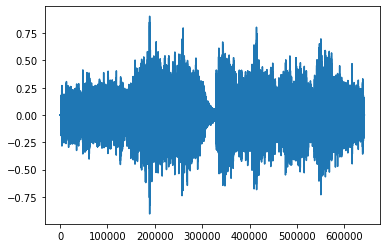

In [3]:
# raw waveform
filename = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\24_preludes_for_solo_piano_wav\jan_hanford-24_preludes_for_solo_piano-01-prelude_no__1_in_f_minor-30-59.wav"

waveform, sr = torchaudio.load(filename)
plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

In [32]:
waveform.min(), waveform.max()

(tensor(-0.9069), tensor(0.9051))

In [105]:
w = np.fft.fft(waveform.squeeze())
freqs = np.fft.fftfreq(len(w))

In [109]:
freqs

array([ 0.00000000e+00,  1.55718368e-06,  3.11436736e-06, ...,
       -4.67155103e-06, -3.11436736e-06, -1.55718368e-06])

In [111]:
w

array([-11.7210083 +2.64233080e-14j,   0.20688839-9.85606115e-02j,
        -0.35255405-6.60789001e-01j, ...,   0.75366763+7.66989973e-01j,
        -0.35255405+6.60789001e-01j,   0.20688839+9.85606115e-02j])

In [104]:
waveform.shape

torch.Size([1, 642185])

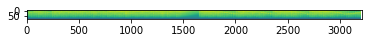

In [10]:
# spectrogram
specgram = torchaudio.transforms.MelSpectrogram(n_mels=80)(waveform)
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())
plt.show()

In [5]:
# split waveform into chunks
chunk_size_s = 2 #s
chunk_size = int(chunk_size_s * sr)

def chunk_waveform(waveform, chunk_size):
    idx = 0
    while idx+chunk_size <= len(waveform):
        yield waveform[idx:idx+chunk_size]
        idx += chunk_size

chunks = torch.FloatTensor(list(chunk_waveform(waveform.numpy().squeeze(), chunk_size)))

C:\Users\jiyun\anaconda3\envs\lex_3.8\lib\site-packages\torchaudio\functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


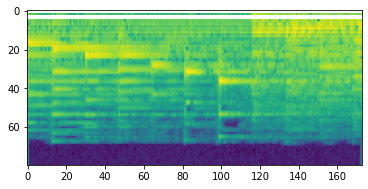

In [223]:
specgram = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=256, hop_length=256)(chunks[10].reshape(1,-1))
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())
plt.show()

In [30]:
specgram.min(), specgram.max()

(tensor(0.), tensor(231.8282))

In [117]:
specgram.shape

torch.Size([1, 80, 345])

In [147]:
# 400 = default window length of spectrogram function
# x2 bc overlap
len(chunks[0])/400 * 2

220.5

In [148]:
# how many seconds is one window looking at?
400/sr

0.018140589569160998

In [21]:
256/2 + 1

129.0

In [224]:
inverse_mel_pred = torchaudio.transforms.InverseMelScale(sample_rate=sr, n_stft=129, n_mels=80)(specgram)

In [225]:
pred_audio = torchaudio.transforms.GriffinLim(n_fft=256)(inverse_mel_pred)

In [226]:
sf.write('test2.wav', pred_audio.squeeze(), sr)

***

In [47]:
import torch.nn as nn
import torch.nn.functional as F

In [205]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=1, padding=1)
#         self.drp = nn.Dropout2d(0.25)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.conv4 = nn.Conv2d(64, 128, 3)
#         self.conv5 = nn.Conv2d(128, 64, 3)
#         self.pool2 = nn.MaxPool2d(4, stride=4)
        self.fc1 = nn.Linear(16, 1)
#         self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
        x = self.pool1(x)
#         x = self.drp(x)
        B, _, H, W = x.shape
        x = x.view(-1,16)
        x = F.relu(self.fc1(x))
        x = x.view(B,1,H, W)
#         x = self.drp(self.pool1(F.relu(self.conv1(x))))
#         x = self.drp(self.pool1(F.relu(self.conv2(x))))
#         x = self.drp(self.pool1(F.relu(self.conv3(x))))
#         x = self.drp(self.pool1(F.relu(self.conv4(x))))
#         x = self.drp(self.pool2(F.relu(self.conv5(x))))
        #size = torch.flatten(x).shape[0]
        #print(x.shape)
#         x = x.view(-1, 64)
        #x = x.unsqueeze_(1)
        #print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        return x

In [206]:
net = Net()

In [207]:
arr_specs = []
for chunk in chunks:
    specgram = torchaudio.transforms.MelSpectrogram(n_mels=80, n_fft=256)(chunk.reshape(1,-1))
    arr_specs.extend(np.array(specgram))

In [208]:
train_specs = torch.FloatTensor(np.array(arr_specs)).unsqueeze(1)

In [209]:
train_specs.shape

torch.Size([14, 1, 80, 345])

In [210]:
outputs = net(train_specs)

In [211]:
outputs.shape

torch.Size([14, 1, 81, 346])

In [151]:
outputs.max(), outputs.min()

(tensor(226.7618, grad_fn=<MaxBackward1>), tensor(0., grad_fn=<MinBackward1>))

In [152]:
specgram.max(), specgram.min()

(tensor(387.2339), tensor(0.))

In [177]:
one_batch = outputs[0].detach()
one_batch = one_batch[:,:-1, :-1]
one_batch.shape

torch.Size([1, 80, 345])

In [164]:
all_batch = outputs.sum(dim=0).detach()
all_batch = all_batch[:,:-1, :-1]

In [165]:
all_batch.max(), all_batch.min()

(tensor(399.2613), tensor(0.0101))

In [169]:
all_batch.shape

torch.Size([1, 80, 345])

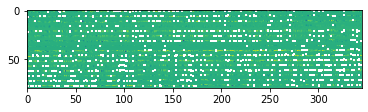

In [178]:
plt.figure()
plt.imshow(one_batch.log2()[0,:,:].numpy())
plt.show()

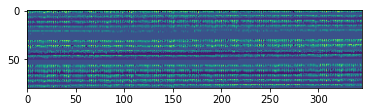

In [167]:
plt.figure()
plt.imshow(all_batch.log2()[0,:,:].numpy())
plt.show()

In [222]:
sr

22050

In [179]:
inverse_mel_pred = torchaudio.transforms.InverseMelScale(sample_rate=sr, n_stft=129, n_mels=80)(one_batch)
pred_audio = torchaudio.transforms.GriffinLim(n_fft=256)(inverse_mel_pred)
sf.write('one_batch.wav', pred_audio.squeeze(), sr)

In [168]:
inverse_mel_pred = torchaudio.transforms.InverseMelScale(sample_rate=sr, n_stft=129, n_mels=80)(all_batch)
pred_audio = torchaudio.transforms.GriffinLim(n_fft=256)(inverse_mel_pred)
sf.write('all_batch.wav', pred_audio.squeeze(), sr)

In [73]:
conv1 = nn.Conv2d(1, 16, 3, padding=1)
pool1 = nn.MaxPool2d(2, stride=1, padding=1)
drp = nn.Dropout2d(0.25)
fc1 = nn.Linear(16, 1)

In [78]:
x = conv1(train_specs)
print(x.shape)
x = F.relu(x)
x = pool1(x)
print(x.shape)
x = drp(x)
x = x.view(-1,16)
x = fc1(x)
x = x.view(14,1,202,222)

torch.Size([14, 16, 201, 221])
torch.Size([14, 16, 202, 222])


In [79]:
x.shape

torch.Size([14, 1, 202, 222])